# Subtask 2: Polarization Detection with DeBERTa v3 (English-Translated Training)




## 1. Environment Setup

In [35]:
# Install required packages
!pip install -q transformers datasets accelerate evaluate
!pip install -q scikit-learn pandas numpy matplotlib seaborn tqdm
!pip install -q wandb

In [36]:
import os
import gc
import json
import random
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import Dataset

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed
)

warnings.filterwarnings('ignore')

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [37]:
# ============================================
# CONFIGURATION - Modify these as needed
# ============================================

class Config:
    # Model configuration
    MODEL_NAME = "microsoft/deberta-v3-base"
    NUM_LABELS = 5
    PROBLEM_TYPE = "multi_label_classification"

    # Training configuration
    MAX_LENGTH = 384
    BATCH_SIZE = 16
    EVAL_BATCH_SIZE = 32
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_RATIO = 0.06
    WEIGHT_DECAY = 0.01
    GRADIENT_ACCUMULATION_STEPS = 1

    # Data configuration
    VALIDATION_SPLIT = 0.1

    # Column configuration
    TEXT_COL = "text_en"
    LABEL_COLS = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
    LANGUAGE_COL = "language"  # if present in the merged data

    # Paths
    TRANSLATIONS_DIR = "./translations"   # folder containing per-language translated CSVs
    OUTPUT_DATASET_PATH = "./english_dataset.csv"
    DEV_PATH = "./dev_english.csv"  # optional
    OUTPUT_DIR = "./output_subtask1_deberta_english"

    # Class weighting
    USE_CLASS_WEIGHTS = True

    # Reproducibility
    SEED = 42

    # Device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()
set_seed(config.SEED)
print(f"Using device: {config.DEVICE}")
print(f"Model: {config.MODEL_NAME}")

Using device: cuda
Model: microsoft/deberta-v3-base


### Calcolo della media delle statistiche per lingua

## 2. Data Loading and Preprocessing

In [38]:
# Mount Google Drive (if data is stored there)
from google.colab import drive
drive.mount('/content/drive')

config.TRANSLATIONS_DIR = './drive/MyDrive/Colab_Data/translations/'
config.OUTPUT_DATASET_PATH = './drive/MyDrive/Colab_Data/output/english_dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
def load_and_merge_translation_csvs(
    translations_dir: str,
    output_path: str,
    drop_cols: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Load all CSV files inside `translations_dir` and concatenate them into a single DataFrame.

    Expected: each CSV contains the translated text column (e.g., `text_en`) and the label column.

    Args:
        translations_dir: Folder containing translated CSVs.
        output_path: Path where the merged CSV will be saved.
        drop_cols: Optional list of columns to drop (e.g., ['text']).

    Returns:
        Merged DataFrame.
    """
    translations_path = Path(translations_dir)
    if not translations_path.exists():
        raise FileNotFoundError(f"Translations directory not found: {translations_path.resolve()}")

    csv_files = sorted([p for p in translations_path.glob("*.csv")])
    if len(csv_files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {translations_path.resolve()}")

    frames = []
    for fp in tqdm(csv_files, desc="Loading translation CSVs"):
        df = pd.read_csv(fp)
        if drop_cols:
            for c in drop_cols:
                if c in df.columns:
                    df = df.drop(columns=[c])
        # If language column is missing, infer from filename
        if config.LANGUAGE_COL not in df.columns:
            lang_guess = fp.stem.split('_')[0]
            df[config.LANGUAGE_COL] = lang_guess
        frames.append(df)

    merged = pd.concat(frames, ignore_index=True)
    merged.to_csv(output_path, index=False)
    print(f"Saved merged dataset -> {output_path}")
    return merged


def load_or_build_english_dataset() -> pd.DataFrame:
    """Load `english_dataset.csv` if present; otherwise build it from translation files."""
    out_path = Path(config.OUTPUT_DATASET_PATH)
    if out_path.exists():
        print(f"Loading existing merged dataset: {out_path.resolve()}")
        return pd.read_csv(out_path)

    print("Merged dataset not found. Building it from translation CSVs...")
    return load_and_merge_translation_csvs(
        translations_dir=config.TRANSLATIONS_DIR,
        output_path=config.OUTPUT_DATASET_PATH,
        drop_cols=['text']
    )


def standardize_for_training(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names for training: text + polarization."""
    if config.TEXT_COL not in df.columns:
        raise ValueError(f"Missing text column: {config.TEXT_COL}. Available: {list(df.columns)}")
    if config.LABEL_COL not in df.columns:
        raise ValueError(f"Missing label column: {config.LABEL_COL}. Available: {list(df.columns)}")

    out = df.copy()
    out = out.rename(columns={config.TEXT_COL: "text", config.LABEL_COL: "polarization"})
    out["text"] = out["text"].astype(str)
    out["polarization"] = out["polarization"].astype(int)
    return out

In [40]:
# Load (or build) the merged dataset
raw_df = load_or_build_english_dataset()
print(raw_df.shape)
raw_df.head()

Loading existing merged dataset: /content/drive/MyDrive/Colab_Data/output/english_dataset.csv
(38444, 8)


,id,political,racial/ethnic,religious,gender/sexual,other,text_en,language
0,arb_a2a60c8b4af3389e842d8ec31afb0eea,0,0,0,1,1,"Dreams of you, of me, of me, of you, until you...",arb
1,arb_6723e56a672674a6c1d9b28b213c4a05,0,0,0,1,1,"An old man's dream, a man's dream, a fantasy o...",arb
2,arb_b0365d606edeee38ae6c025b1ca33e96,0,0,0,1,1,The queen's peaches are dreams of the gay thin...,arb
3,arb_858c0ee684049ba6f416a6cecb0b0761,0,0,0,1,1,God disgraces the dreams of her and the hopele...,arb
4,arb_bdafc73afd0bc2cd2badae2a089446b9,0,0,0,0,1,"The mother of dreams shall be made unto her, a...",arb


In [41]:
# Prepare DataFrame for multi-label classification
df = raw_df.copy()

if config.TEXT_COL != "text":
    df = df.rename(columns={config.TEXT_COL: "text"})

# Ensure label columns are integer type
for col in config.LABEL_COLS:
    if col not in df.columns:
        raise ValueError(f"Missing label column: {col}. Available: {list(df.columns)}")
    df[col] = df[col].astype(int)

if config.LANGUAGE_COL in raw_df.columns:
    df[config.LANGUAGE_COL] = raw_df[config.LANGUAGE_COL].astype(str)

print(df.shape)
df.head()

(38444, 8)


,id,political,racial/ethnic,religious,gender/sexual,other,text,language
0,arb_a2a60c8b4af3389e842d8ec31afb0eea,0,0,0,1,1,"Dreams of you, of me, of me, of you, until you...",arb
1,arb_6723e56a672674a6c1d9b28b213c4a05,0,0,0,1,1,"An old man's dream, a man's dream, a fantasy o...",arb
2,arb_b0365d606edeee38ae6c025b1ca33e96,0,0,0,1,1,The queen's peaches are dreams of the gay thin...,arb
3,arb_858c0ee684049ba6f416a6cecb0b0761,0,0,0,1,1,God disgraces the dreams of her and the hopele...,arb
4,arb_bdafc73afd0bc2cd2badae2a089446b9,0,0,0,0,1,"The mother of dreams shall be made unto her, a...",arb


In [42]:
# Basic checks
print("Columns:", df.columns.tolist())
print("\nLabel distribution:")
print(df["political"].value_counts())

Columns: ['id', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other', 'text', 'language']

Label distribution:
political
0    26119
1    12325
Name: count, dtype: int64


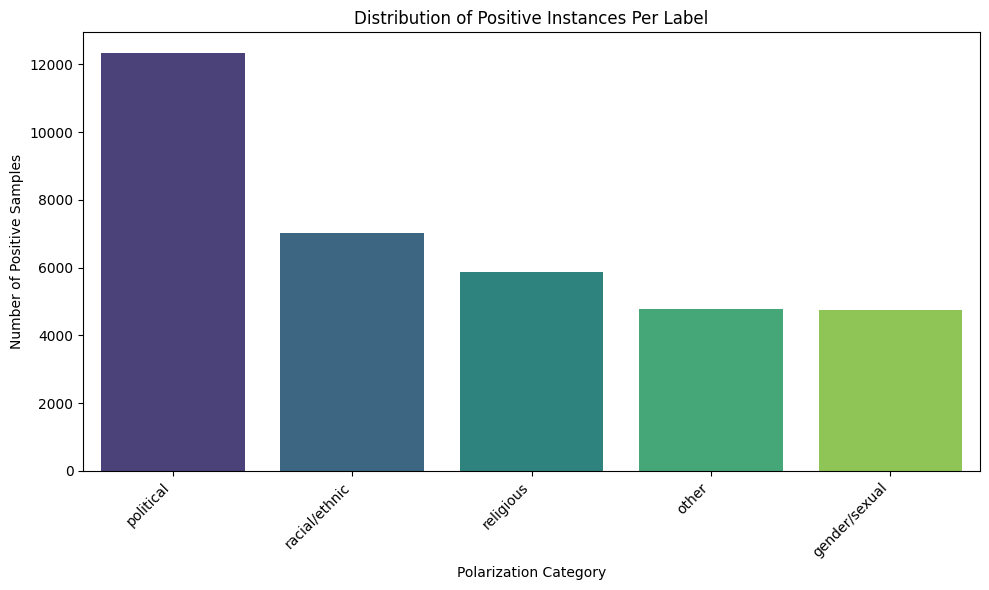

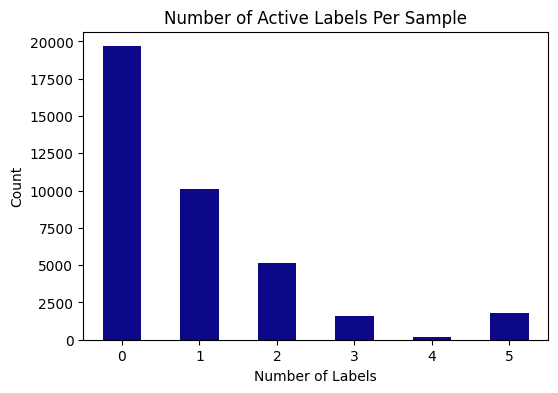

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize class distribution for each label
plt.figure(figsize=(10, 6))


positive_counts = df[config.LABEL_COLS].sum().sort_values(ascending=False)

sns.barplot(x=positive_counts.index, y=positive_counts.values, palette='viridis')
plt.title("Distribution of Positive Instances Per Label")
plt.xlabel("Polarization Category")
plt.ylabel("Number of Positive Samples")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Count number of labels per sample
df['num_labels'] = df[config.LABEL_COLS].sum(axis=1)
plt.figure(figsize=(6, 4))
df['num_labels'].value_counts().sort_index().plot(kind='bar', cmap='plasma')
plt.title("Number of Active Labels Per Sample")
plt.xlabel("Number of Labels")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [44]:
# Create train/validation split with stratification PER LANGUAGE for multi-label

combined_train_data = []
val_data_by_language = {}

df_filtered_for_split = df.copy()

# Ensure the 'language' column is present for per-language split
if config.LANGUAGE_COL not in df_filtered_for_split.columns:
    print(f"Warning: '{config.LANGUAGE_COL}' column not found for per-language split. Falling back to global split.")
    df_filtered_for_split["has_any_polarization"] = df_filtered_for_split[config.LABEL_COLS].max(axis=1).astype(str)
    train_data, val_data = train_test_split(
        df_filtered_for_split,
        test_size=config.VALIDATION_SPLIT,
        random_state=config.SEED,
        stratify=df_filtered_for_split["has_any_polarization"]
    )
    combined_train_data.append(train_data)
    val_data_by_language["global"] = val_data
else:
    for lang in df_filtered_for_split[config.LANGUAGE_COL].unique():
        lang_df = df_filtered_for_split[df_filtered_for_split[config.LANGUAGE_COL] == lang].copy()


        if not lang_df.empty:
            lang_df["has_any_polarization"] = lang_df[config.LABEL_COLS].max(axis=1).astype(str)

            # Create stratification column combining language and polarization presence
            stratify_col_name = "strat_col_" + lang
            lang_df[stratify_col_name] = lang_df[config.LANGUAGE_COL] + "_" + lang_df["has_any_polarization"]

            # Handle rare strata
            strat_counts = lang_df[stratify_col_name].value_counts()
            min_samples = 2  # Minimum samples per stratum for stratified split
            valid_strata = strat_counts[strat_counts >= min_samples].index
            lang_df_filtered = lang_df[lang_df[stratify_col_name].isin(valid_strata)].copy()

            if len(lang_df_filtered) < len(lang_df):
                print(f"Dropping {len(lang_df) - len(lang_df_filtered)} samples from language '{lang}' with rare strata (<{min_samples} samples).")

            if len(lang_df_filtered) > 0 and len(lang_df_filtered[stratify_col_name].unique()) > 1:
                lang_train, lang_val = train_test_split(
                    lang_df_filtered,
                    test_size=config.VALIDATION_SPLIT,
                    random_state=config.SEED,
                    stratify=lang_df_filtered[stratify_col_name]
                )
                combined_train_data.append(lang_train)
                val_data_by_language[lang] = lang_val
            elif len(lang_df_filtered) > 0:
                 print(f"Warning: Only one stratum for language '{lang}', cannot stratify. Performing non-stratified split.")
                 lang_train, lang_val = train_test_split(
                    lang_df_filtered,
                    test_size=config.VALIDATION_SPLIT,
                    random_state=config.SEED
                )
                 combined_train_data.append(lang_train)
                 val_data_by_language[lang] = lang_val
            else:
                print(f"No sufficient data for language '{lang}' to create splits.")

# Concatenate all training dataframes
train_data = pd.concat(combined_train_data, ignore_index=True)

print("Train data shape:", train_data.shape)
print("Validation data shapes per language:")
for lang, df_val in val_data_by_language.items():
    print(f"  {lang}: {df_val.shape}")

print("\nTrain label distribution (percentage of positive instances per label):")
for col in config.LABEL_COLS:
    print(f"  {col}: {train_data[col].sum() / len(train_data) * 100:.2f}%")

print("\nValidation label distribution per language (percentage of positive instances per label):")
for lang, df_val in val_data_by_language.items():
    print(f"--- Language: {lang} ---")
    for col in config.LABEL_COLS:
        if not df_val.empty:
            print(f"  {col}: {df_val[col].sum() / len(df_val) * 100:.2f}%")
        else:
            print(f"  {col}: N/A (empty dataframe)")

Train data shape: (34594, 22)
Validation data shapes per language:
  arb: (338, 11)
  ben: (334, 11)
  deu: (318, 11)
  eng: (323, 11)
  hin: (275, 11)
  ita: (334, 11)
  pol: (240, 11)
  rus: (335, 11)
  spa: (331, 11)
  tur: (237, 11)
  urd: (357, 11)
  zho: (428, 11)

Train label distribution (percentage of positive instances per label):
  political: 32.08%
  racial/ethnic: 18.19%
  religious: 15.26%
  gender/sexual: 12.34%
  other: 12.45%

Validation label distribution per language (percentage of positive instances per label):
--- Language: arb ---
  political: 23.08%
  racial/ethnic: 17.16%
  religious: 6.51%
  gender/sexual: 13.31%
  other: 14.50%
--- Language: ben ---
  political: 32.63%
  racial/ethnic: 1.50%
  religious: 3.59%
  gender/sexual: 0.30%
  other: 9.28%
--- Language: deu ---
  political: 40.88%
  racial/ethnic: 19.50%
  religious: 10.69%
  gender/sexual: 5.97%
  other: 13.52%
--- Language: eng ---
  political: 35.60%
  racial/ethnic: 8.67%
  religious: 3.41%
  gende

## 3. Dataset Class and Tokenization

In [45]:
class PolarizationDataset(Dataset):
    """
    PyTorch Dataset for polarization classification.
    Handles tokenization and proper formatting for transformers.
    """

    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
      encoding = self.tokenizer(
          self.texts[idx],
          truncation = True,
          padding = False,
          max_length = self.max_length,
          return_tensors = "pt"
      )

      item = {k: v.squeeze(0) for k, v in encoding.items()}

      if self.labels is not None:
          item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)

      return item

In [46]:
# Load tokenizer
print(f"Loading tokenizer: {config.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

Loading tokenizer: microsoft/deberta-v3-base


In [47]:
# Create train dataset
y_train = train_data[config.LABEL_COLS].values

train_dataset = PolarizationDataset(
    texts=train_data["text"].tolist(),
    labels=y_train,
    tokenizer=tokenizer,
    max_length=config.MAX_LENGTH
)

# Create a dictionary of validation datasets, one for each language
val_datasets = {}
for lang, df_val in val_data_by_language.items():
    if not df_val.empty:
        y_val_lang = df_val[config.LABEL_COLS].values
        val_datasets[lang] = PolarizationDataset(
            texts=df_val["text"].tolist(),
            labels=y_val_lang,
            tokenizer=tokenizer,
            max_length=config.MAX_LENGTH
        )
    else:
        val_datasets[lang] = None

# Optional: dev dataset (no labels)
dev_dataset = None
dev_path = Path(config.DEV_PATH)
if dev_path.exists():
    dev_df = pd.read_csv(dev_path)
    # Expect a 'text_en' or 'text' column
    if config.TEXT_COL in dev_df.columns:
        dev_texts = dev_df[config.TEXT_COL].astype(str).tolist()
    elif "text" in dev_df.columns:
        dev_texts = dev_df["text"].astype(str).tolist()
    else:
        raise ValueError(f"Dev file found but missing text column. Columns: {dev_df.columns.tolist()}")

    dev_dataset = PolarizationDataset(
        texts=dev_texts,
        labels=None,
        tokenizer=tokenizer,
        max_length=config.MAX_LENGTH
    )
    print(f"Dev dataset size: {len(dev_dataset)}")
else:
    print("No dev file found (DEV_PATH). Skipping dev dataset.")

print(f"Train dataset size: {len(train_dataset)}")
print("Validation dataset sizes per language:")
for lang, dataset in val_datasets.items():
    if dataset:
        print(f"  {lang}: {len(dataset)}")
    else:
        print(f"  {lang}: Empty")

No dev file found (DEV_PATH). Skipping dev dataset.
Train dataset size: 34594
Validation dataset sizes per language:
  arb: 338
  ben: 334
  deu: 318
  eng: 323
  hin: 275
  ita: 334
  pol: 240
  rus: 335
  spa: 331
  tur: 237
  urd: 357
  zho: 428


## 4. Model Setup

In [48]:
# Compute class weights for handling imbalance
if config.USE_CLASS_WEIGHTS:
    pos_weights = []
    for label_col in config.LABEL_COLS:
        pos_count = train_data[label_col].sum()
        neg_count = len(train_data) - pos_count
        pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
        pos_weights.append(pos_weight)

    pos_weights = torch.tensor(pos_weights, dtype=torch.float32).to(config.DEVICE)
    print(f"Pos weights per class: {pos_weights}")
else:
    pos_weights = None

# Load model with multi-label configuration
print(f"Loading model: {config.MODEL_NAME}")

model_config = AutoConfig.from_pretrained(
    config.MODEL_NAME,
    num_labels=5,
    problem_type="multi_label_classification"
)

model = AutoModelForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    config=model_config
)
model.to(config.DEVICE)

# Data collator (dynamic padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Pos weights per class: tensor([2.1174, 4.4963, 5.5544, 7.1016, 7.0320], device='cuda:0')
Loading model: microsoft/deberta-v3-base


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5. Training Setup

In [49]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for multi-label classification.
    Primary metric: Macro F1 (as specified in Subtask 2)
    """
    predictions, labels = eval_pred


    probs = torch.sigmoid(torch.tensor(predictions))
    preds = (probs > 0.5).long().numpy()
    labels = labels.astype(int)

    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)
    f1_micro = f1_score(labels, preds, average="micro", zero_division=0)
    accuracy = accuracy_score(labels, preds)
    # Changed average from default 'binary' to 'macro' for multi-label classification
    precision = precision_score(labels, preds, average="macro", zero_division=0)
    recall = recall_score(labels, preds, average="macro", zero_division=0)

    # F1 for each class
    f1_per_class = f1_score(labels, preds, average=None, zero_division=0)

    return {
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_political": f1_per_class[0],
        "f1_racial_ethnic": f1_per_class[1],
        "f1_religious": f1_per_class[2],
        "f1_gender_sexual": f1_per_class[3],
        "f1_other": f1_per_class[4],
    }

In [50]:
class WeightedTrainer(Trainer):
    """
    Custom Trainer that supports class weights for imbalanced datasets.
    """

    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            loss_fn = BCEWithLogitsLoss(pos_weight=self.class_weights)
        else:
            loss_fn = BCEWithLogitsLoss()

        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [51]:
# Create output directory
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,

    # Training hyperparameters
    num_train_epochs=config.NUM_EPOCHS,
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.EVAL_BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,

    # Optimization
    warmup_ratio=config.WARMUP_RATIO,
    weight_decay=config.WEIGHT_DECAY,
    optim="adamw_torch",
    lr_scheduler_type="cosine",

    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    # Logging
    logging_dir=os.path.join(config.OUTPUT_DIR, "logs"),
    logging_steps=50,
    report_to="none",
    save_total_limit=2,

    # Performance
    fp16=torch.cuda.is_available(),
)

In [52]:
# Combine all validation datasets for the Trainer's main evaluation
combined_val_for_trainer = []
for lang, dataset in val_datasets.items():
    if dataset:
        combined_val_for_trainer.append(dataset)

# Concatenate datasets if there are any, otherwise set to None
if combined_val_for_trainer:
    all_val_texts = []
    all_val_labels = []
    for ds in combined_val_for_trainer:
        all_val_texts.extend(ds.texts)
        all_val_labels.extend(ds.labels)

    overall_eval_dataset = PolarizationDataset(
        texts=all_val_texts,
        labels=all_val_labels,
        tokenizer=tokenizer,
        max_length=config.MAX_LENGTH
    )
else:
    overall_eval_dataset = None


# Create trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=overall_eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=pos_weights
)

## 6. Training

In [53]:
# Clear GPU memory before training
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Starting training...")
print("="*60)

# Train the model
train_result = trainer.train()

print("="*60)
print("Training completed!")


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy,Precision,Recall,F1 Political,F1 Racial Ethnic,F1 Religious,F1 Gender Sexual,F1 Other
1,0.806000,0.793321,0.548674,0.559603,0.399740,0.442324,0.761402,0.673149,0.564869,0.609646,0.500971,0.394737
2,0.682400,0.836170,0.585283,0.600593,0.478961,0.499879,0.714543,0.680365,0.585556,0.638773,0.570492,0.451229
3,0.571000,0.871873,0.584791,0.600515,0.492727,0.495511,0.723729,0.687666,0.589011,0.631507,0.577236,0.438533


Training completed!


In [54]:
# Print training metrics
print("\nTraining Metrics:")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"  Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"  Final training loss: {train_result.metrics['train_loss']:.4f}")


Training Metrics:
  Total training time: 1632.42s
  Samples/second: 63.58
  Final training loss: 0.7378


In [55]:
# Evaluate on validation sets per language
print("\nEvaluation on Validation Sets per Language:")

all_eval_metrics = {}

for lang, dataset in val_datasets.items():
    if dataset:
        eval_metrics = trainer.evaluate(eval_dataset=dataset)
        all_eval_metrics[lang] = eval_metrics
    else:
        print(f"Skipping Language: {lang} (Empty dataset)")

# Print results table
print("\nResults by language:")
print(f"{'Lang':<6} {'F1-Macro':>10} {'Precision':>12} {'Recall':>10} {'Accuracy':>10}")
print("-" * 52)

for lang, metrics in all_eval_metrics.items():
    f1 = metrics.get("eval_f1_macro", 0.0)
    prec = metrics.get("eval_precision", 0.0)
    rec = metrics.get("eval_recall", 0.0)
    acc = metrics.get("eval_accuracy", 0.0)

    print(f"{lang:<6} {f1:10.4f} {prec:12.4f} {rec:10.4f} {acc:10.4f}")



Evaluation on Validation Sets per Language:



Results by language:
Lang     F1-Macro    Precision     Recall   Accuracy
----------------------------------------------------
arb        0.5245       0.4318     0.7031     0.4793
ben        0.2946       0.2154     0.6528     0.5030
deu        0.5251       0.5265     0.5387     0.4434
eng        0.4140       0.3647     0.4939     0.6533
hin        0.5145       0.4897     0.5615     0.3200
ita        0.3211       0.2410     0.4926     0.4192
pol        0.4765       0.3946     0.7006     0.5167
rus        0.4575       0.3609     0.6601     0.5731
spa        0.5825       0.4914     0.7273     0.3656
tur        0.4505       0.4324     0.5292     0.4177
urd        0.6989       0.6208     0.8038     0.4118
zho        0.5502       0.4565     0.6993     0.5864


In [62]:
# Calculate the arithmetic mean of the statistics across all languages
avg_f1_macro = np.mean([metrics.get("eval_f1_macro", 0.0) for metrics in all_eval_metrics.values()])
avg_precision = np.mean([metrics.get("eval_precision", 0.0) for metrics in all_eval_metrics.values()])
avg_recall = np.mean([metrics.get("eval_recall", 0.0) for metrics in all_eval_metrics.values()])
avg_accuracy = np.mean([metrics.get("eval_accuracy", 0.0) for metrics in all_eval_metrics.values()])

print("\n--- Mean per language ---")
print(f"  F1-Macro: {avg_f1_macro:.4f}")
print(f"  Precision: {avg_precision:.4f}")
print(f"  Recall: {avg_recall:.4f}")
print(f"  Accuracy: {avg_accuracy:.4f}")


--- Mean per language ---
  F1-Macro: 0.4842
  Precision: 0.4188
  Recall: 0.6302
  Accuracy: 0.4741


## 7. Save Model

In [56]:
# Save the best model + tokenizer
trainer.save_model(config.OUTPUT_DIR)
tokenizer.save_pretrained(config.OUTPUT_DIR)

print(f"Saved model to: {config.OUTPUT_DIR}")

Saved model to: ./output_subtask1_deberta_english


## 8. Save predictions

In [58]:
# Save predictions to CSV for each evaluated set
for name, data_dict in all_predictions_by_language.items():
    pred_labels = data_dict["pred_labels"]
    original_df = data_dict["original_df"]

    if not original_df.empty:
        pred_out_path = os.path.join(config.OUTPUT_DIR, f"predictions_{name}.csv")
        out_df = original_df.reset_index(drop=True).copy()
        out_df[config.LABEL_COLS] = pred_labels
        out_df.to_csv(pred_out_path, index=False)
        print(f"Saved predictions for {name} -> {pred_out_path}")
    else:
        print(f"Skipping saving predictions for {name} (Empty dataframe).")

Saved predictions for arb -> ./output_subtask1_deberta_english/predictions_arb.csv
Saved predictions for ben -> ./output_subtask1_deberta_english/predictions_ben.csv
Saved predictions for deu -> ./output_subtask1_deberta_english/predictions_deu.csv
Saved predictions for eng -> ./output_subtask1_deberta_english/predictions_eng.csv
Saved predictions for hin -> ./output_subtask1_deberta_english/predictions_hin.csv
Saved predictions for ita -> ./output_subtask1_deberta_english/predictions_ita.csv
Saved predictions for pol -> ./output_subtask1_deberta_english/predictions_pol.csv
Saved predictions for rus -> ./output_subtask1_deberta_english/predictions_rus.csv
Saved predictions for spa -> ./output_subtask1_deberta_english/predictions_spa.csv
Saved predictions for tur -> ./output_subtask1_deberta_english/predictions_tur.csv
Saved predictions for urd -> ./output_subtask1_deberta_english/predictions_urd.csv
Saved predictions for zho -> ./output_subtask1_deberta_english/predictions_zho.csv


## 9. Load Saved Model (for later use)

In [59]:
# Load the saved model for inference later

loaded_tokenizer = AutoTokenizer.from_pretrained(config.OUTPUT_DIR)
loaded_model = AutoModelForSequenceClassification.from_pretrained(config.OUTPUT_DIR)
loaded_model.to(config.DEVICE)

print("Loaded model + tokenizer from:", config.OUTPUT_DIR)

The tokenizer you are loading from './output_subtask1_deberta_english' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loaded model + tokenizer from: ./output_subtask1_deberta_english
